In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")
print(emotions)

/Users/dominikwunderlich/Developer/huggingface-textklassifizierung/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [3]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
print(df.head())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [4]:
# Add labelname to the dataset
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df['labelname'] = df['label'].apply(label_int2str)
print(df.head())

                                                text  label labelname
0                            i didnt feel humiliated      0   sadness
1  i can go from feeling so hopeless to so damned...      0   sadness
2   im grabbing a minute to post i feel greedy wrong      3     anger
3  i am ever feeling nostalgic about the fireplac...      2      love
4                               i am feeling grouchy      3     anger


1. Dataexploring mithilfe von Pandas und Matplotlib

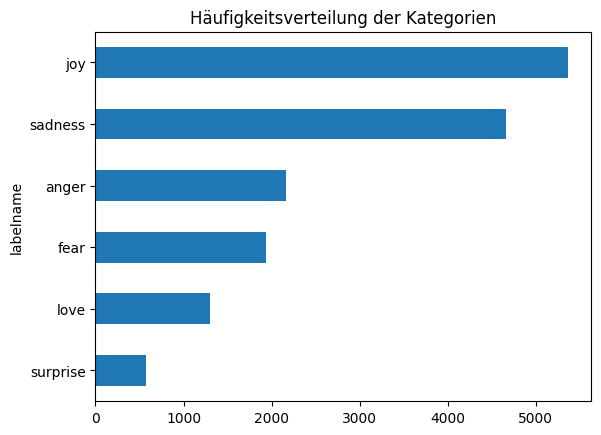

In [5]:
import matplotlib.pyplot as plt

df['labelname'].value_counts(ascending=True).plot.barh()
plt.title('Häufigkeitsverteilung der Kategorien')
plt.show()

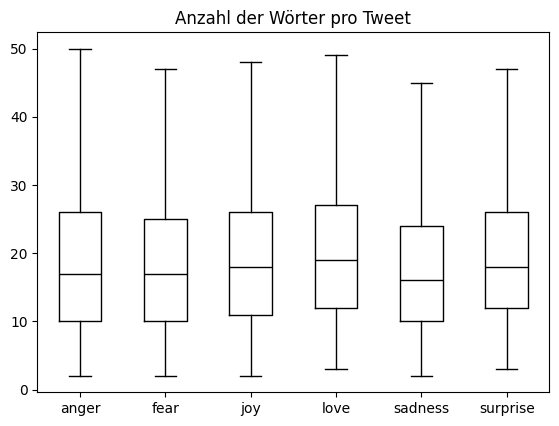

In [6]:
# Wie lange sind unsere Tweets?
df["Anzahl der Wörter pro Tweet"] = df['text'].str.split().apply(len)
df.boxplot("Anzahl der Wörter pro Tweet", by="labelname", grid=False, showfliers=False, color="black")
plt.suptitle('')
plt.xlabel("")
plt.show()

Die Länge der Tweets liegt bei ~15 Wörtern je Emotion. Selbst die längsten Tweets liegen unter der maximalen Kontextlänge von DistilBERT. Das bedeutet es ist eine Kürzung notwendig. Im folgenden konvertieren wir nun die Rohtexte in ein Format, dass sich für die Transformer-Bibliothek eignet. DataFrame-Format wird auch zurück gesetzt, da es nicht mehr benötigt wird. 

In [7]:
# Zurücksetzen des DataFormats
emotions.reset_format()

Vom Text zu Tokens: 

In [8]:
from transformers import AutoTokenizer

# Laden des Tokenizers
# DistilBERT ist ein vortrainiertes Modell, das wir für unser Sentiment Analysis Modell verwenden
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [9]:
# Sehen wir uns an, wie der Tokenizer funktioniert
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [10]:
# Nachdem wir nun die input_ids vorliegen haben, können wir sie wieder in Tokens konvertieren:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [11]:
# So bringen wir mit dem AutoTokenizer unsere tokens zurück in eine Zeichenkette: 
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


VORSICHT! Wenn ich ein vortrainiertes Modell nutze, dann muss ich darauf achten den gleichen Tokenizer zu verwenden, der auch beim Training verwendet wurde. Aus Sicht des Modells ist ein Wechsel des Tokenizers wie eine Umstellung des Vokabulars. 

In [12]:
# Bearbeitungsfunktion um die Texte zu tokenisieren
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [13]:
# Map-Methode: Anwenden der Tokenisierungsfunktion auf das gesamte Dataset
emotions_encoded = emotions.map(tokenize_function, batched=True, batch_size=None)
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Transformermodelle als Feature Extraktoren. 
Mit dieser Methode frieren wir die Gewichtung des Bodys während des Trainings ein und verwenden die verborgenen Zustände als Features für den Klassifikator. 

In [14]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Shape des Eingabe-Tensors: {inputs['input_ids'].size()}")

Shape des Eingabe-Tensors: torch.Size([1, 6])


In [16]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [17]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [18]:
def extract_hidden_states(batch):
    # Modelleingaben auf der GPU platzieren
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # Letzte verborgene Zustände extrahieren
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Vektor für [CLS] Token zurückgeben
    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}
    

In [19]:
emotions_encoded.set_format(type='torch',
                             columns=['input_ids', 'attention_mask', 'label'])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [20]:
# Erstellen der Feature Matrix
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
Y_train = np.array(emotions_hidden["train"]["label"])
Y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_81339/665721088.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = np.array(emotions_hidden["train"]["hidden state"])
/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_81339/665721088.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_valid = np.array(emotions_hidden["validation"]["hidden state"])
/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_81339/665721088.py:6: DeprecationWarni

((16000, 768), (2000, 768))

In [21]:
# Trainieren eines Klassifikators
from sklearn.linear_model import LogisticRegression

# Wir erhöhen 'max_iter' , um sicherzustellen, dass das Modell konvergiert
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, Y_train)
lr_clf.score(X_valid, Y_valid)


0.634

Genauigkeit = 63% (Klassifikator auf DistilBERT-Embeddings). Prüfen wir im folgenden mit der DummyClassifier-Klasse ein Baseline Modell.

In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, Y_train)
dummy_clf.score(X_valid, Y_valid)
    

0.352

Genauigkeit des baseline modells liegt bei 35%. Das zeigt dass das Modell basierend auf DistilBERT bereits besser abschneidet. 

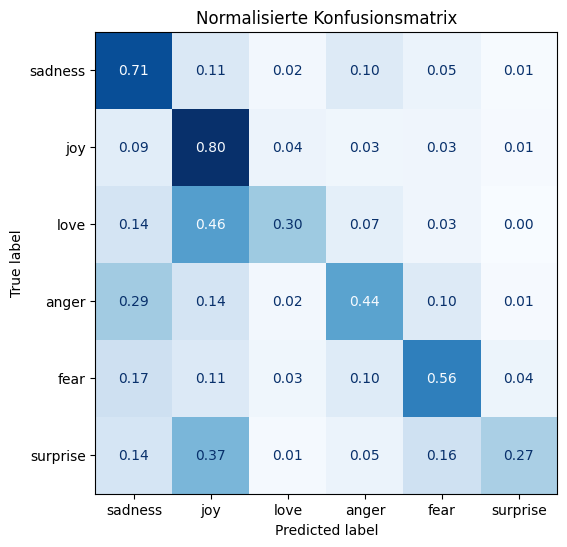

In [23]:
# Leistung des Modells besser untersuchen, mit einer Konfusionsmatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fiq, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalisierte Konfusionsmatrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, Y_valid, labels)

Es zeigt sich dass das Model häufig "anger" und "fear" mit "sadness" und "love" und "surprise" mit "joy" verwechselt.

# Finetuning von Transformer-Modellen: 

Im Rahmen des Feintunings wird das gesamte DistilBERT-Modell zusammen mit dem Klassifizierungs-Head trainiert. Dafür wird auf die Huggingface "Trainer"-Klasse zurückgegriffen. 

In [24]:
# Als ersten benötigen wir ein vortrainiertes DistilBERT Modell
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Wir definieren eine Funktion, die die Modellvorhersagen berechnet
# Im Rahmen dieser Anwendung werden wir das F1-Score verwenden und die Treffergenauigkeit (Accuracy) berechnen
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}

In [26]:
# Hyperparater für das Training festlegen
import torch
from transformers import Trainer, TrainingArguments

# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to MPS
model = model.to(device)

# Adjust batch size (reduce if you run into memory issues)
batch_size = 32 

# Compute logging steps dynamically
logging_steps = len(emotions_encoded["train"]) // batch_size

# Define model name
model_name = f"{model_ckpt}-finetuned-emotions"

# Training arguments
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    save_strategy="epoch",
    load_best_model_at_end=True,
    log_level="error"
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
)

# Train the model
trainer.train()


/Users/dominikwunderlich/Developer/huggingface-textklassifizierung/.venv/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Using device: mps


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.641900,0.228765,0.914466,0.914000
2,0.171600,0.175374,0.934366,0.934500


TrainOutput(global_step=1000, training_loss=0.4067401428222656, metrics={'train_runtime': 184.0848, 'train_samples_per_second': 173.833, 'train_steps_per_second': 5.432, 'total_flos': 720342861696000.0, 'train_loss': 0.4067401428222656, 'epoch': 2.0})

In [27]:
# weiteres Modell
from transformers import Trainer, TrainingArguments

batch_size=64
logging_steps = len(emotions_encoded["train"]) # batch_size
model_name = f"{model_ckpt}-finetuned-emotions-2"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    save_strategy="epoch",
    load_best_model_at_end=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()


/Users/dominikwunderlich/Developer/huggingface-textklassifizierung/.venv/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/kt/0951cp5901jfqvm_wv2pg1800000gn/T/ipykernel_81339/3465656560.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.150523,0.937677,0.937500
2,No log,0.135280,0.941839,0.941500


TrainOutput(global_step=500, training_loss=0.1264799118041992, metrics={'train_runtime': 165.8242, 'train_samples_per_second': 192.975, 'train_steps_per_second': 3.015, 'total_flos': 720342861696000.0, 'train_loss': 0.1264799118041992, 'epoch': 2.0})

In [29]:
# Konfusionsmatrix aufbauen
# Damit wir die Konfusionsmatrix visualisieren können, müssen wir ermitteln, welche Vorhersagen das Modell für die Validierungsdaten getroffen hat.
preds_output = trainer.predict(emotions_encoded["validation"])


In [30]:
# Vorhersagen im gleichen Format wie beim feature basierenden Ansatz
y_preds = np.argmax(preds_output.predictions, axis=1)

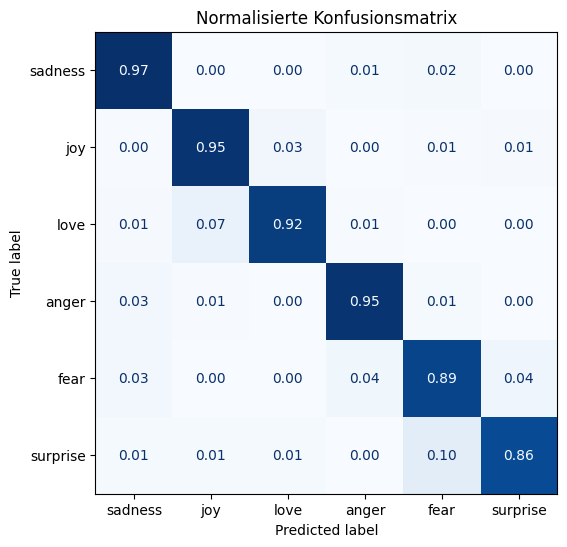

In [31]:
# Konfusionsmatrix visualisieren
plot_confusion_matrix(y_preds, Y_valid, labels)